# 03 - Feature Engineering Experiments

This notebook experiments with different feature engineering approaches to improve gesture recognition.

## Features to Explore
1. **Velocity** - Frame-to-frame position changes
2. **Acceleration** - Rate of velocity change
3. **Finger Angles** - Angles at finger joints
4. **Hand Bounding Box** - Size and aspect ratio for distance awareness
5. **Relative Positions** - Fingertip positions relative to wrist/palm

In [1]:
# Imports
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from handflow.features import FeatureEngineer
from handflow.utils import load_config

plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Imports loaded")

✅ Imports loaded


In [8]:
# Load configuration
config = load_config()

# Data paths
DATA_PATH = Path('../data/raw/MP_Data')
if not DATA_PATH.exists():
    DATA_PATH = Path('../ModelTraining/MP_Data')

ACTIONS = config.right_hand_gestures
print(f"📁 Data path: {DATA_PATH}")
print(f"🎯 Actions: {ACTIONS}")

📁 Data path: ../data/raw/MP_Data
🎯 Actions: ['none', 'nonezoom', 'swiperight', 'zoom', 'pointyclick', 'middleclick', 'ringclick', 'pinkyclick']


In [3]:
def load_all_data(data_path, actions, max_per_class=50):
    """
    Load data for all gesture classes.
    """
    all_sequences = []
    all_labels = []
    
    for action in actions:
        action_path = data_path / action
        if not action_path.exists():
            continue
        
        seq_dirs = sorted([d for d in action_path.iterdir() if d.is_dir()])[:max_per_class]
        
        for seq_dir in seq_dirs:
            frames = []
            for frame_num in range(16):
                frame_path = seq_dir / f"{frame_num}.npy"
                if frame_path.exists():
                    frames.append(np.load(frame_path))
            
            if len(frames) == 16:
                all_sequences.append(np.array(frames))
                all_labels.append(action)
    
    return np.array(all_sequences), np.array(all_labels)

# Load data
print("📥 Loading data...")
sequences, labels = load_all_data(DATA_PATH, ACTIONS, max_per_class=50)
print(f"   Loaded: {sequences.shape}")
print(f"   Labels: {len(labels)}")

📥 Loading data...
   Loaded: (350, 16, 84)
   Labels: 350


## 1. Velocity Features

In [9]:
def compute_velocity(sequence):
    """
    Compute frame-to-frame velocity.
    
    Args:
        sequence: (16, 84) array
    
    Returns:
        velocity: (16, 84) array (first frame is zeros)
    """
    velocity = np.diff(sequence, axis=0, prepend=sequence[0:1])
    return velocity

# Test on single sequence
sample_seq = sequences[0]
sample_velocity = compute_velocity(sample_seq)

print(f"Original shape: {sample_seq.shape}")
print(f"Velocity shape: {sample_velocity.shape}")
print(f"Velocity range: [{sample_velocity.min():.4f}, {sample_velocity.max():.4f}]")

Original shape: (16, 84)
Velocity shape: (16, 84)
Velocity range: [-1.1995, 0.4329]


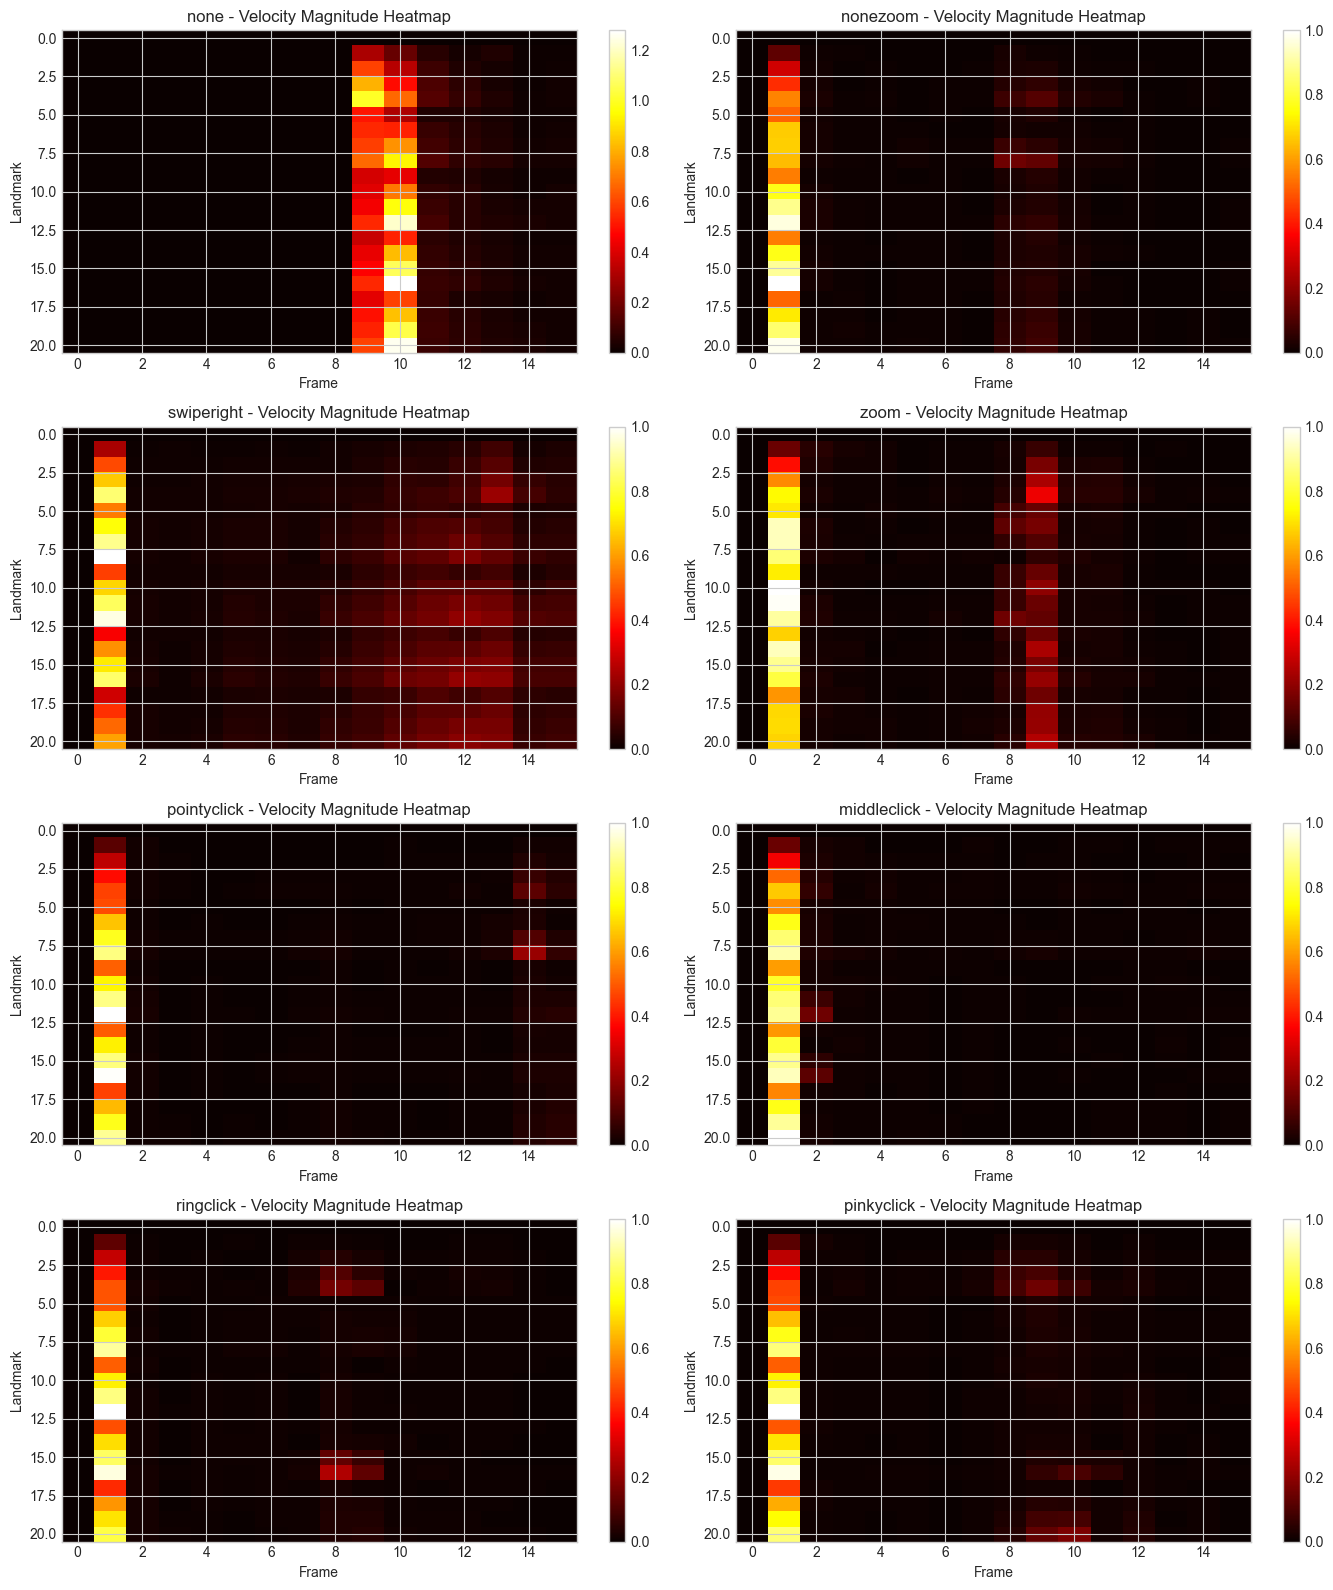

In [14]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Collect samples
gesture_samples = {}
for action in ACTIONS:
    sample = sequences[labels == action]
    gesture_samples[action] = sample[0] if len(sample) > 0 else None

# ---- dynamic layout ----
N = len(gesture_samples)
n_cols = 2                      # change to 3 if you want wider layout
n_rows = math.ceil(N / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(7 * n_cols, 4 * n_rows),
    squeeze=False
)

axes = axes.flatten()

# ---- plotting ----
for idx, (gesture, seq) in enumerate(gesture_samples.items()):
    if seq is None:
        continue

    ax = axes[idx]

    velocity = compute_velocity(seq)
    velocity_magnitude = np.linalg.norm(
        velocity.reshape(16, 21, 4)[:, :, :3],
        axis=2
    )

    im = ax.imshow(
        velocity_magnitude.T,
        aspect='auto',
        cmap='hot'
    )

    ax.set_xlabel('Frame')
    ax.set_ylabel('Landmark')
    ax.set_title(f'{gesture} - Velocity Magnitude Heatmap')
    fig.colorbar(im, ax=ax)

# ---- remove unused subplots ----
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../docs/velocity_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()


## 2. Acceleration Features

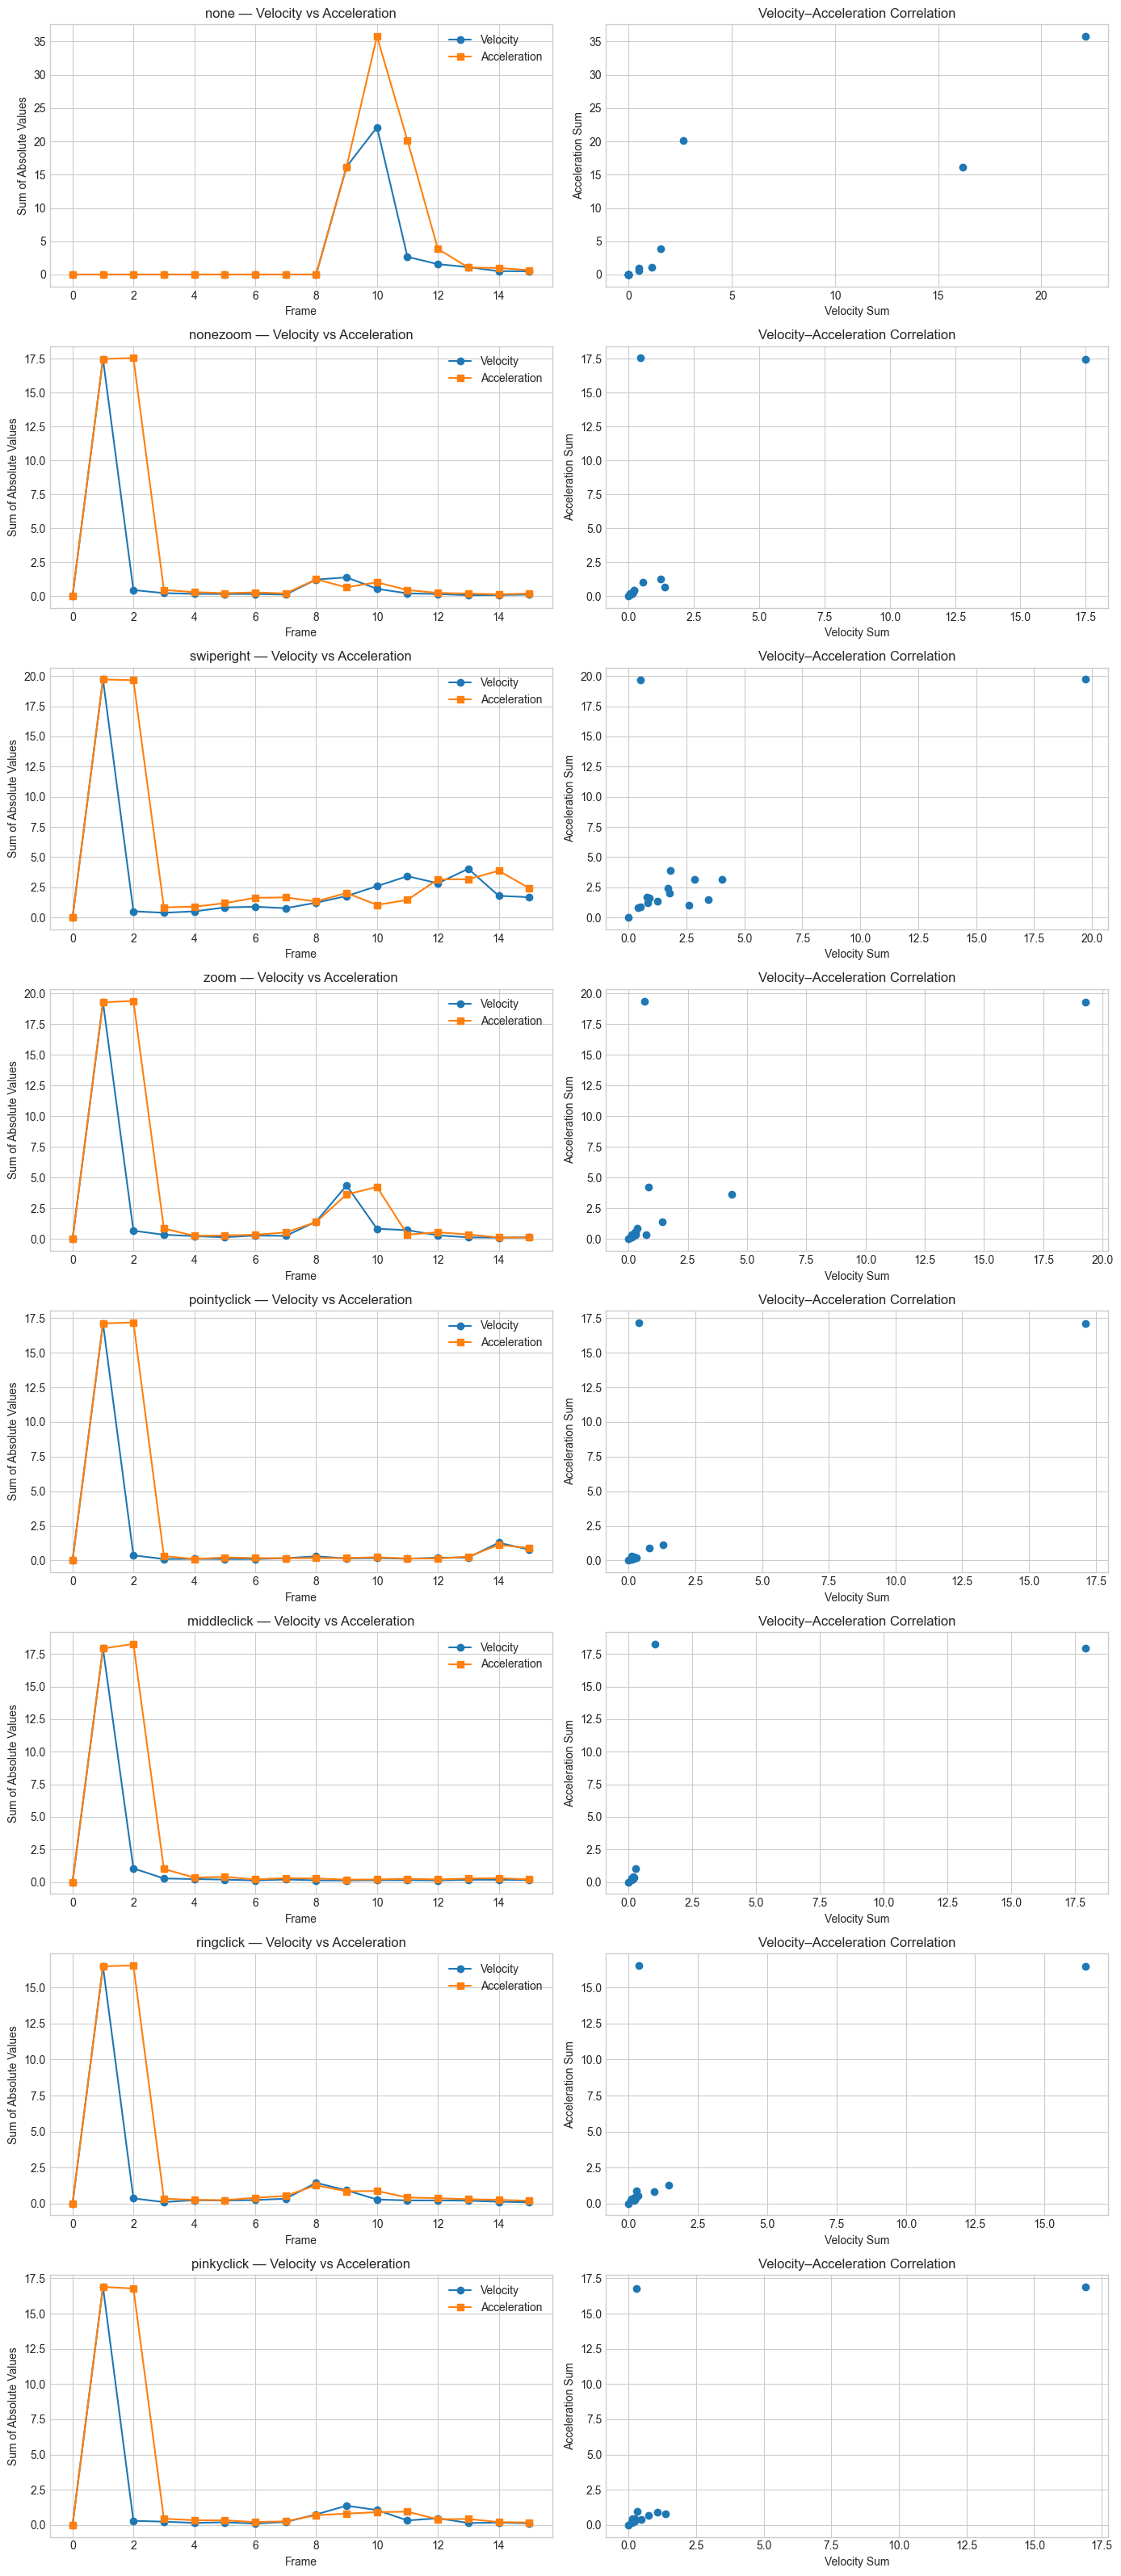

In [16]:
import math
import matplotlib.pyplot as plt
import numpy as np

def compute_acceleration(sequence):
    """
    Compute frame-to-frame acceleration (rate of velocity change).

    Returns:
        acceleration: (T, 84) array
    """
    velocity = compute_velocity(sequence)
    acceleration = np.diff(velocity, axis=0, prepend=velocity[0:1])
    return acceleration


# ---- layout based on number of gestures ----
valid_gestures = [(g, s) for g, s in gesture_samples.items() if s is not None]
N = len(valid_gestures)

fig, axes = plt.subplots(
    N,
    2,
    figsize=(14, 4 * N),
    squeeze=False
)

# ---- plotting ----
for row, (gesture, sample) in enumerate(valid_gestures):

    velocity = compute_velocity(sample)
    acceleration = compute_acceleration(sample)

    # Sum across all keypoints
    vel_sum = np.abs(velocity).sum(axis=1)
    acc_sum = np.abs(acceleration).sum(axis=1)

    # --- Time-series plot ---
    ax_ts = axes[row, 0]
    ax_ts.plot(vel_sum, marker='o', label='Velocity')
    ax_ts.plot(acc_sum, marker='s', label='Acceleration')
    ax_ts.set_xlabel('Frame')
    ax_ts.set_ylabel('Sum of Absolute Values')
    ax_ts.set_title(f'{gesture} — Velocity vs Acceleration')
    ax_ts.legend()

    # --- Scatter plot ---
    ax_scatter = axes[row, 1]
    ax_scatter.scatter(vel_sum, acc_sum)
    ax_scatter.set_xlabel('Velocity Sum')
    ax_scatter.set_ylabel('Acceleration Sum')
    ax_scatter.set_title('Velocity–Acceleration Correlation')

plt.tight_layout()
plt.show()


## 3. Finger Angle Features

In [25]:
# Finger joint indices for angle calculation
FINGER_JOINTS = [
    # Thumb
    (0, 1, 2), (1, 2, 3), (2, 3, 4),
    # Index
    (0, 5, 6), (5, 6, 7), (6, 7, 8),
    # Middle
    (0, 9, 10), (9, 10, 11), (10, 11, 12),
    # Ring
    (0, 13, 14), (13, 14, 15), (14, 15, 16),
    # Pinky
    (0, 17, 18), (17, 18, 19), (18, 19, 20),
]

def calculate_angle(p1, p2, p3):
    """
    Calculate angle at p2 formed by p1-p2-p3.
    
    Returns:
        angle in radians normalized to [0, 1]
    """
    v1 = p1 - p2
    v2 = p3 - p2
    
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle = np.arccos(cos_angle)
    
    return angle / np.pi  # Normalize to [0, 1]

def compute_finger_angles(sequence):
    """
    Compute all 15 finger joint angles for each frame.
    
    Returns:
        angles: (16, 15) array
    """
    num_frames = sequence.shape[0]
    angles = np.zeros((num_frames, 15))
    
    for frame_idx in range(num_frames):
        landmarks = sequence[frame_idx].reshape(21, 4)[:, :3]  # x, y, z only
        
        for joint_idx, (p1, p2, p3) in enumerate(FINGER_JOINTS):
            angles[frame_idx, joint_idx] = calculate_angle(
                landmarks[p1], landmarks[p2], landmarks[p3]
            )
    
    return angles

# Test
sample_angles = compute_finger_angles(sequences[0])
print(f"Angles shape: {sample_angles.shape}")
print(f"Angle range: [{sample_angles.min():.4f}, {sample_angles.max():.4f}]")

Angles shape: (16, 15)
Angle range: [0.5000, 0.9982]


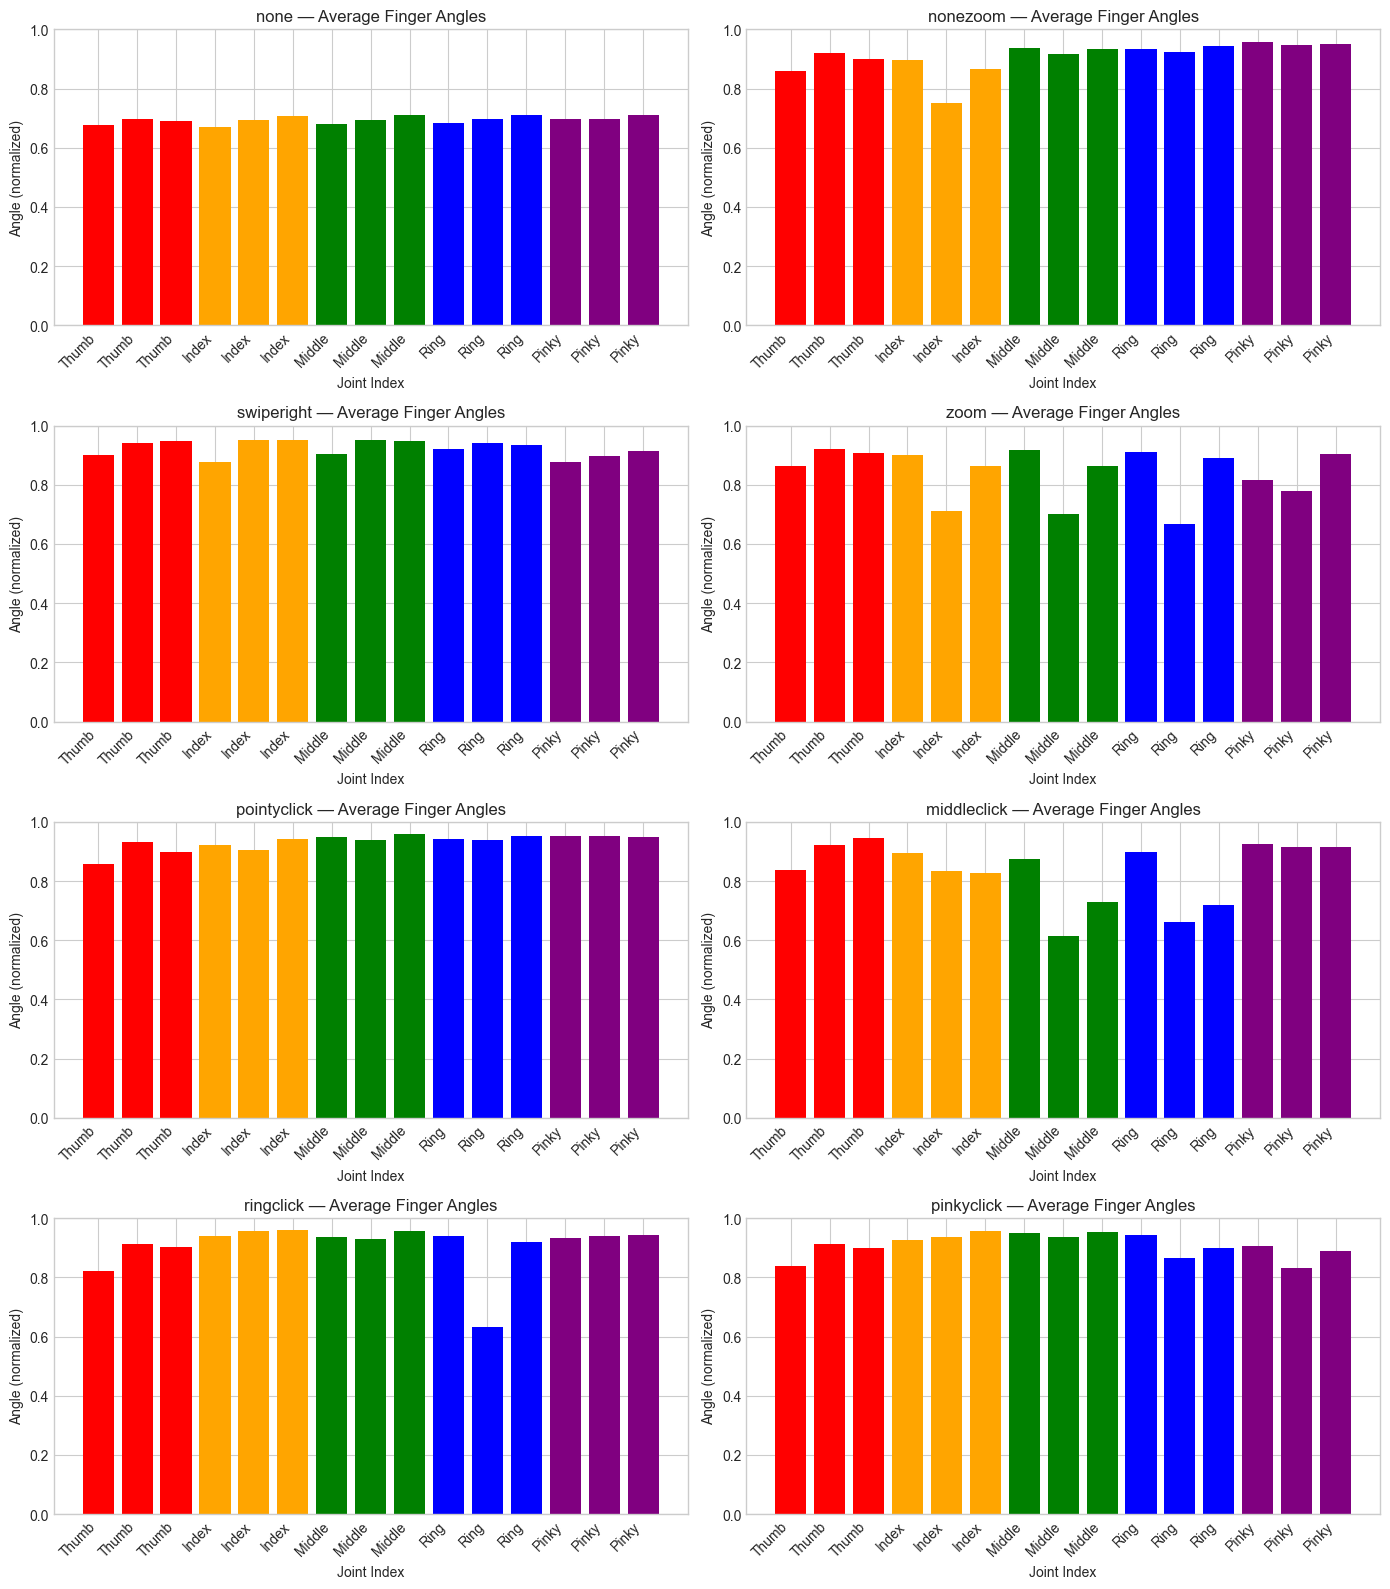

In [28]:
import math
import matplotlib.pyplot as plt
import numpy as np

# ---- layout based on number of gestures ----
valid_gestures = [(g, s) for g, s in gesture_samples.items() if s is not None]
N = len(valid_gestures)

n_cols = 2
n_rows = math.ceil(N / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(7 * n_cols, 4 * n_rows),
    squeeze=False
)

axes = axes.flatten()

# ---- constants ----
finger_names = (
    ['Thumb'] * 3 +
    ['Index'] * 3 +
    ['Middle'] * 3 +
    ['Ring'] * 3 +
    ['Pinky'] * 3
)

colors = (
    ['red'] * 3 +
    ['orange'] * 3 +
    ['green'] * 3 +
    ['blue'] * 3 +
    ['purple'] * 3
)

# ---- plotting ----
for idx, (gesture, seq) in enumerate(valid_gestures):
    ax = axes[idx]

    angles = compute_finger_angles(seq)

    # Average over frames
    avg_angles = angles.mean(axis=0)

    ax.bar(range(15), avg_angles, color=colors)
    ax.set_xlabel('Joint Index')
    ax.set_ylabel('Angle (normalized)')
    ax.set_title(f'{gesture} — Average Finger Angles')
    ax.set_ylim(0, 1)

    # Optional: label fingers
    ax.set_xticks(range(15))
    ax.set_xticklabels(finger_names, rotation=45, ha='right')

# ---- remove unused axes ----
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../docs/finger_angles.png', dpi=150, bbox_inches='tight')
plt.show()


## 4. Hand Bounding Box Features

In [29]:
def compute_bbox_features(sequence):
    """
    Compute hand bounding box features.
    
    Features:
    - width: horizontal span
    - height: vertical span
    - area: width * height (indicates distance from camera)
    - aspect_ratio: width / height
    
    Returns:
        bbox_features: (16, 4) array
    """
    num_frames = sequence.shape[0]
    bbox_features = np.zeros((num_frames, 4))
    
    for frame_idx in range(num_frames):
        landmarks = sequence[frame_idx].reshape(21, 4)
        
        x_coords = landmarks[:, 0]
        y_coords = landmarks[:, 1]
        
        width = x_coords.max() - x_coords.min()
        height = y_coords.max() - y_coords.min()
        area = width * height
        aspect_ratio = width / (height + 1e-8)
        
        bbox_features[frame_idx] = [width, height, area, aspect_ratio]
    
    return bbox_features

# Test
sample_bbox = compute_bbox_features(sequences[0])
print(f"Bbox features shape: {sample_bbox.shape}")
print(f"Width range: [{sample_bbox[:, 0].min():.4f}, {sample_bbox[:, 0].max():.4f}]")

Bbox features shape: (16, 4)
Width range: [0.0000, 1.1159]


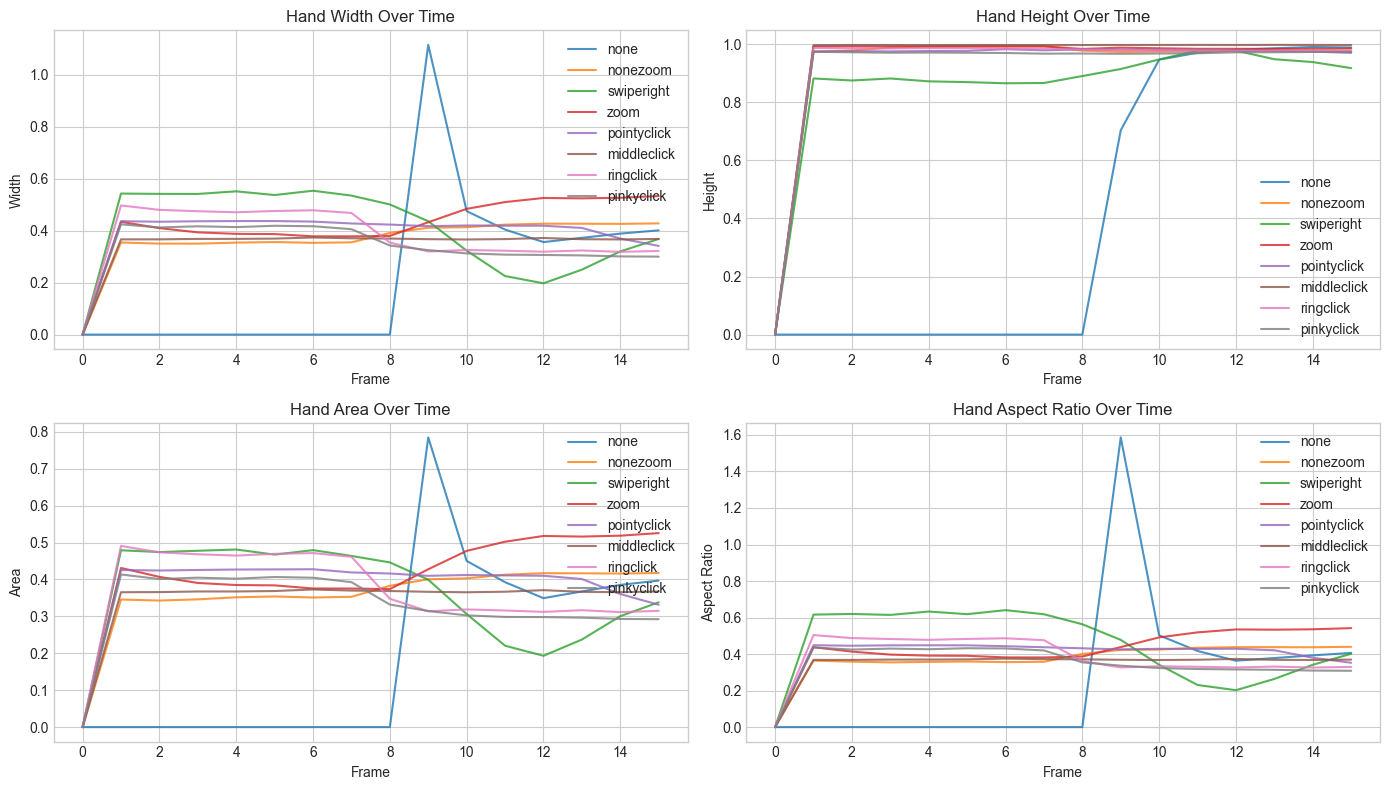

In [31]:
import matplotlib.pyplot as plt

# ---- layout: one subplot per bbox feature ----
feature_names = ['Width', 'Height', 'Area', 'Aspect Ratio']
n_features = len(feature_names)

n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(7 * n_cols, 4 * n_rows),
    squeeze=False
)

axes = axes.flatten()

# ---- plot all gestures ----
for gesture, seq in gesture_samples.items():
    if seq is None:
        continue

    bbox = compute_bbox_features(seq)  # (T, 4)

    for feat_idx, feat_name in enumerate(feature_names):
        axes[feat_idx].plot(
            bbox[:, feat_idx],
            label=gesture,
            alpha=0.8
        )

# ---- axis formatting ----
for feat_idx, feat_name in enumerate(feature_names):
    ax = axes[feat_idx]
    ax.set_xlabel('Frame')
    ax.set_ylabel(feat_name)
    ax.set_title(f'Hand {feat_name} Over Time')
    ax.legend()

# ---- remove unused axes (if any) ----
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../docs/bbox_features.png', dpi=150, bbox_inches='tight')
plt.show()


## 7. Inter-finger distances (pinch detection)

In [38]:
def compute_inter_finger_distances(sequence):
    """
    Compute distances between adjacent fingertips over time.

    Returns:
        distances: (T, 4)
    """
    num_frames = sequence.shape[0]   # ✅ fixed
    distances = np.zeros((num_frames, 4))

    # Fingertip landmark indices
    pairs = [(4, 8), (8, 12), (12, 16), (16, 20)]

    for i, (p1, p2) in enumerate(pairs):
        p1_coords = sequence[:, p1*4 : p1*4 + 3]
        p2_coords = sequence[:, p2*4 : p2*4 + 3]
        distances[:, i] = np.linalg.norm(p1_coords - p2_coords, axis=1)

    return distances


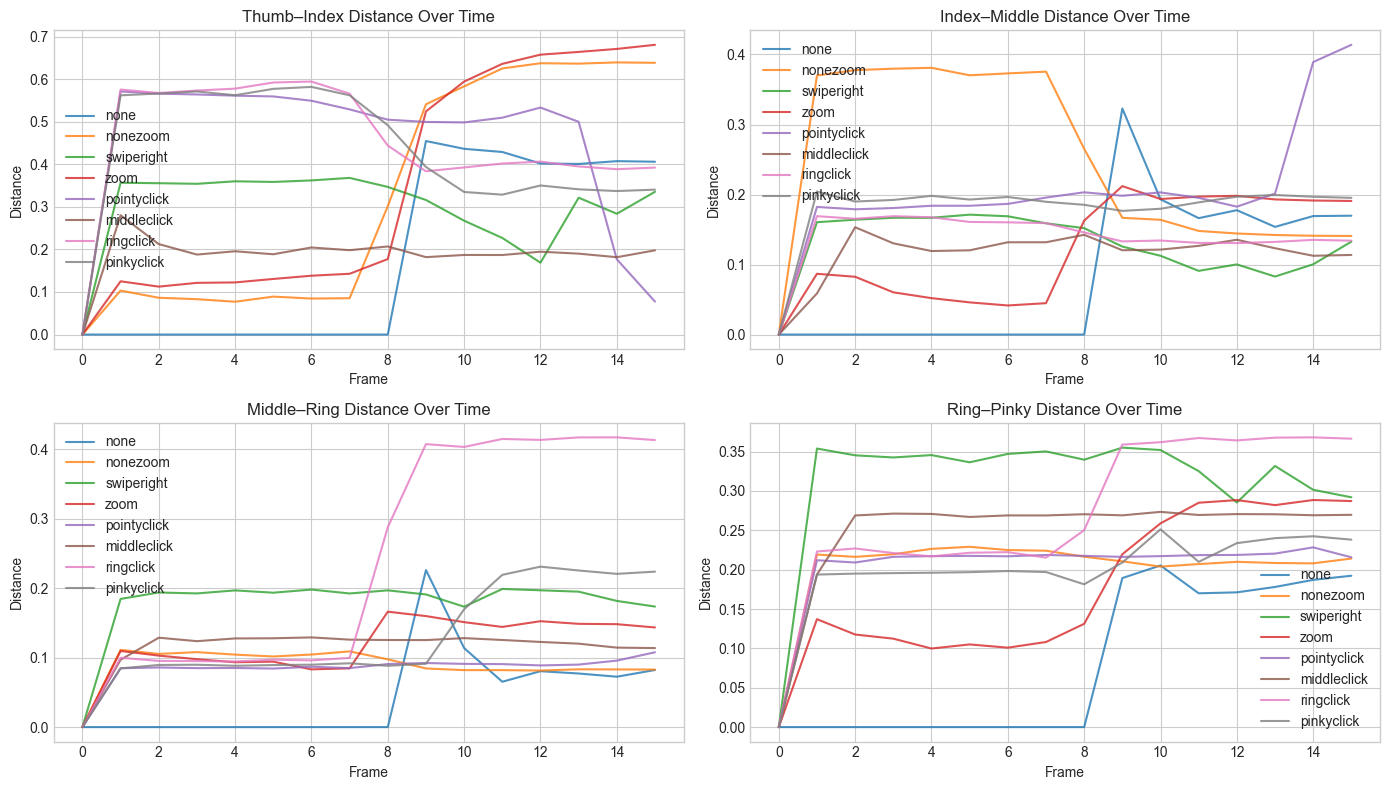

In [39]:
import matplotlib.pyplot as plt

distance_names = [
    'Thumb–Index',
    'Index–Middle',
    'Middle–Ring',
    'Ring–Pinky'
]

n_features = len(distance_names)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(7 * n_cols, 4 * n_rows),
    squeeze=False
)

axes = axes.flatten()

# ---- plot all gestures ----
for gesture, seq in gesture_samples.items():
    if seq is None:
        continue

    distances = compute_inter_finger_distances(seq)  # (T, 4)

    for feat_idx, feat_name in enumerate(distance_names):
        axes[feat_idx].plot(
            distances[:, feat_idx],
            label=gesture,
            alpha=0.8
        )

# ---- formatting ----
for feat_idx, feat_name in enumerate(distance_names):
    ax = axes[feat_idx]
    ax.set_xlabel('Frame')
    ax.set_ylabel('Distance')
    ax.set_title(f'{feat_name} Distance Over Time')
    ax.legend()

# ---- remove unused axes ----
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../docs/inter_finger_distances.png', dpi=150, bbox_inches='tight')
plt.show()


# 7. Finger curl (Fist/open detection) 

In [41]:
def compute_finger_curl(sequence):
    """
    Compute distance from finger tips to wrist (Landmark 0)
    """
    num_frames = sequence.shape[0]
    curls = np.zeros((num_frames, 5))

    tips = [4, 8, 12, 16, 20]
    wrist = sequence[:, 0:3] 
    
    for i, tip in enumerate(tips): 
        tip_coords = sequence[:, tip*4 : tip*4+3]
        curls[:, i] = np.linalg.norm(tip_coords - wrist, axis=1)
        
    return curls

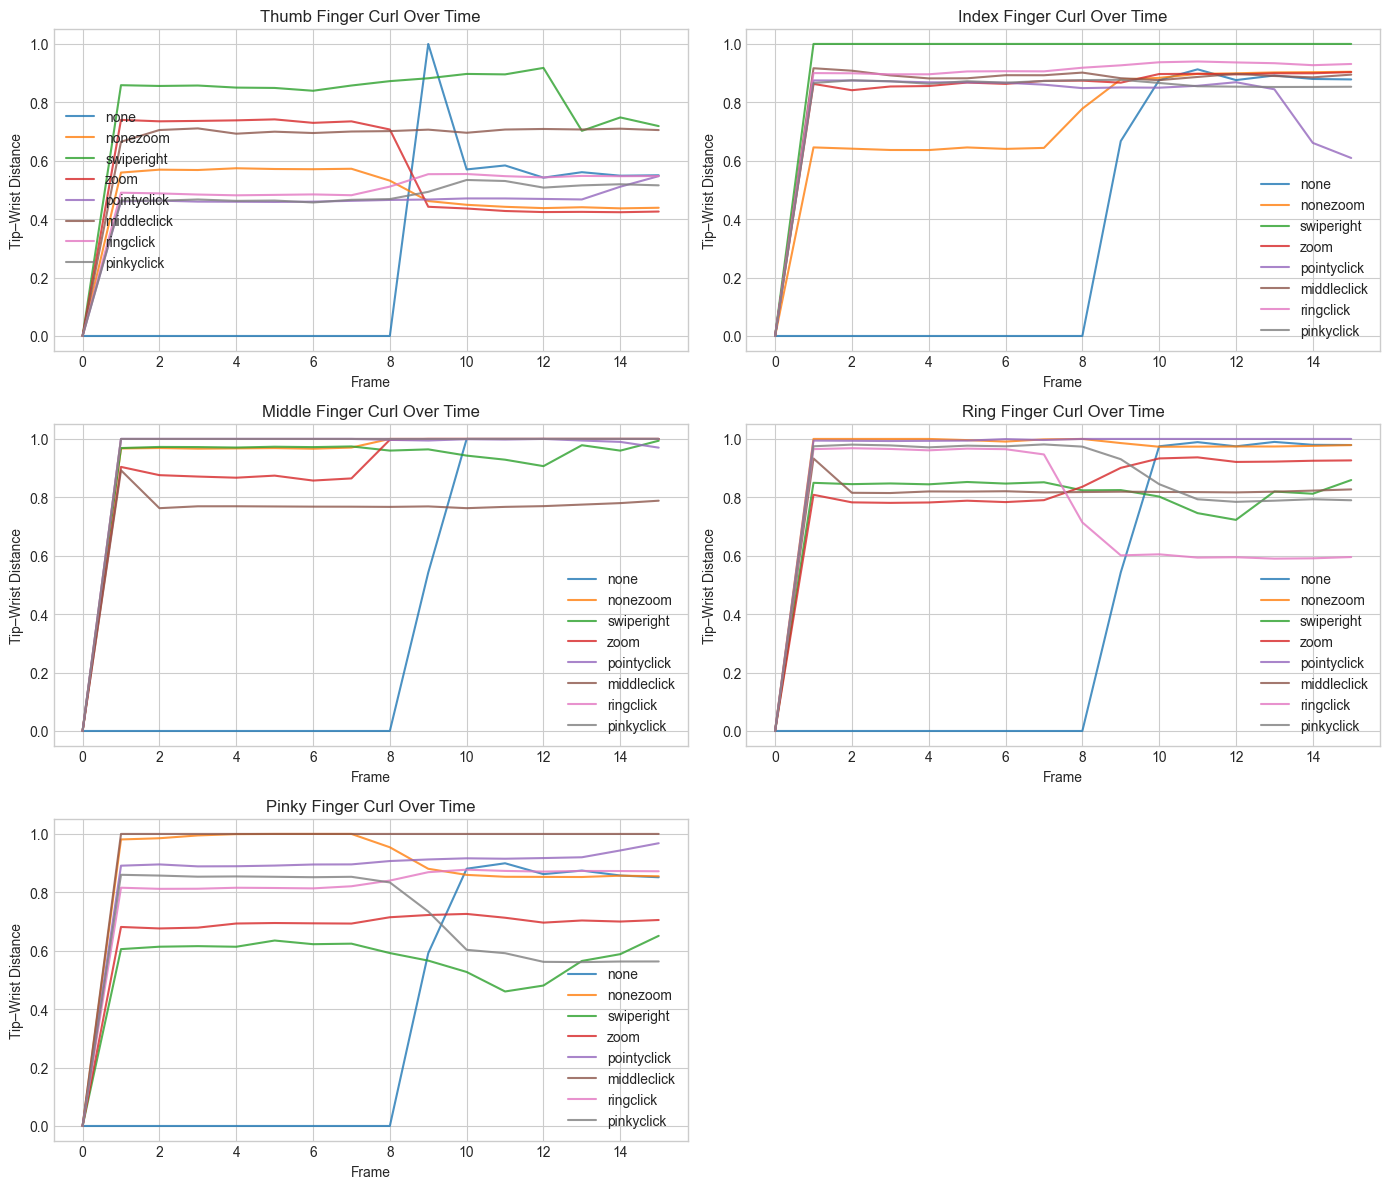

In [42]:
import matplotlib.pyplot as plt

finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
n_features = len(finger_names)

n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(7 * n_cols, 4 * n_rows),
    squeeze=False
)

axes = axes.flatten()

# ---- plot all gestures ----
for gesture, seq in gesture_samples.items():
    if seq is None:
        continue

    curls = compute_finger_curl(seq)  # (T, 5)

    for feat_idx, finger in enumerate(finger_names):
        axes[feat_idx].plot(
            curls[:, feat_idx],
            label=gesture,
            alpha=0.8
        )

# ---- formatting ----
for feat_idx, finger in enumerate(finger_names):
    ax = axes[feat_idx]
    ax.set_xlabel('Frame')
    ax.set_ylabel('Tip–Wrist Distance')
    ax.set_title(f'{finger} Finger Curl Over Time')
    ax.legend()

# ---- remove unused axes ----
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../docs/finger_curl.png', dpi=150, bbox_inches='tight')
plt.show()


## 8. Palm orientation (palm normal)

In [43]:
def compute_palm_orientation(sequence: np.ndarray) -> np.ndarray:
    """
    Compute palm normal vector via cross product of:
    Wrist -> Index MCP  and  Wrist -> Pinky MCP.

    Args:
        sequence: np.ndarray of shape (T, 21*4)
                  Each landmark = (x, y, z, visibility)

    Returns:
        normals: np.ndarray of shape (T, 3)
    """
    wrist = sequence[:, 0:3]                     # Landmark 0
    index_mcp = sequence[:, 5*4 : 5*4 + 3]       # Landmark 5
    pinky_mcp = sequence[:, 17*4 : 17*4 + 3]     # Landmark 17

    v1 = index_mcp - wrist
    v2 = pinky_mcp - wrist

    cross = np.cross(v1, v2)
    norms = np.linalg.norm(cross, axis=1, keepdims=True)

    normals = cross / (norms + 1e-8)
    return normals


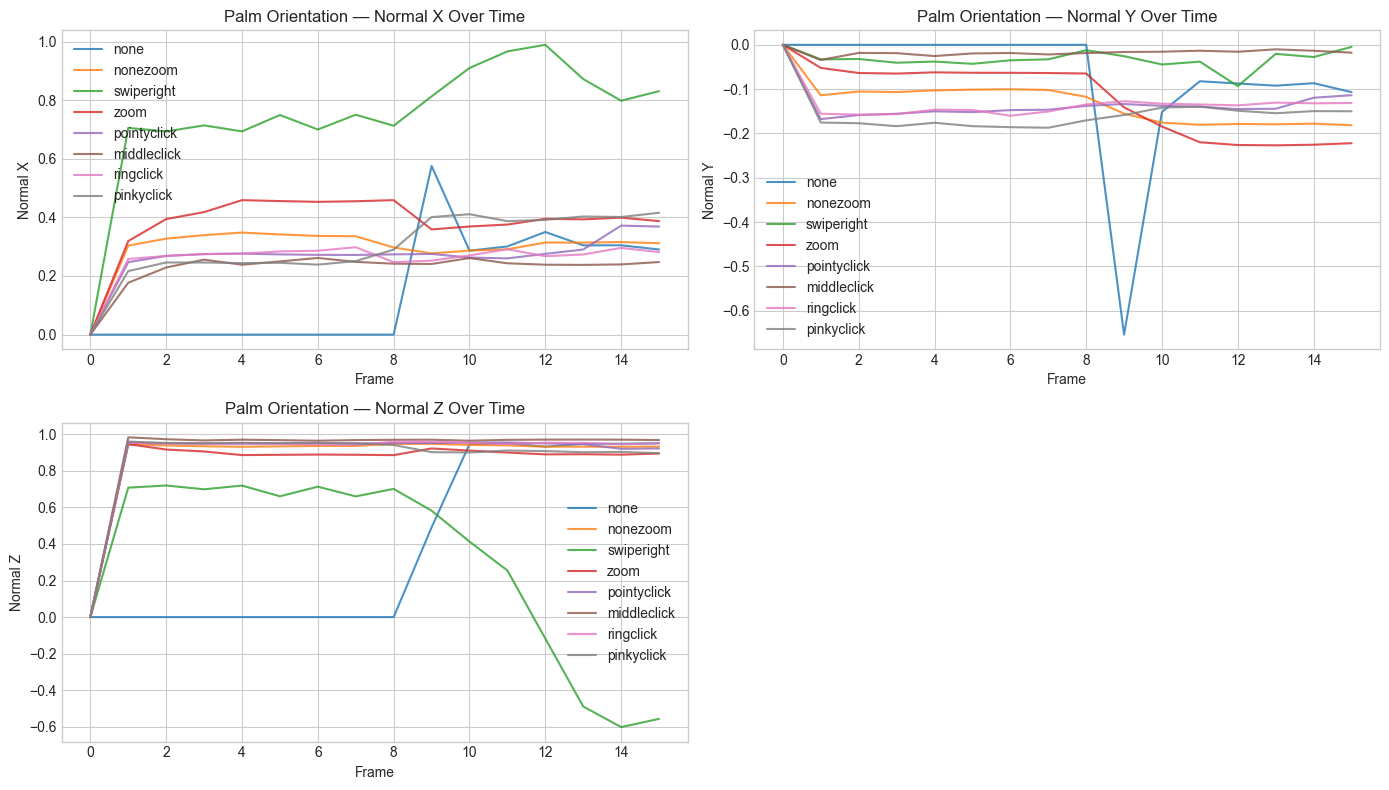

In [44]:
import matplotlib.pyplot as plt

component_names = ['Normal X', 'Normal Y', 'Normal Z']
n_features = len(component_names)

n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(7 * n_cols, 4 * n_rows),
    squeeze=False
)

axes = axes.flatten()

# ---- plot all gestures ----
for gesture, seq in gesture_samples.items():
    if seq is None:
        continue

    normals = compute_palm_orientation(seq)  # (T, 3)

    for feat_idx, comp in enumerate(component_names):
        axes[feat_idx].plot(
            normals[:, feat_idx],
            label=gesture,
            alpha=0.8
        )

# ---- formatting ----
for feat_idx, comp in enumerate(component_names):
    ax = axes[feat_idx]
    ax.set_xlabel('Frame')
    ax.set_ylabel(comp)
    ax.set_title(f'Palm Orientation — {comp} Over Time')
    ax.legend()

# ---- remove unused axes ----
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../docs/palm_orientation.png', dpi=150, bbox_inches='tight')
plt.show()


## 6. Feature Importance Visualization with PCA

In [33]:
# Apply feature engineering to all data
print("🔧 Applying feature engineering...")
transformed_sequences = np.array([engineer.transform(seq) for seq in sequences])
print(f"   Shape: {transformed_sequences.shape}")

# Flatten to (n_samples, n_features)
X = transformed_sequences.reshape(len(sequences), -1)
print(f"   Flattened: {X.shape}")

🔧 Applying feature engineering...
   Shape: (350, 16, 271)
   Flattened: (350, 4336)


In [34]:
# PCA for dimensionality visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained: {pca.explained_variance_ratio_.sum():.2%}")

Explained variance ratio: [0.15970549 0.0921216 ]
Total explained: 25.18%


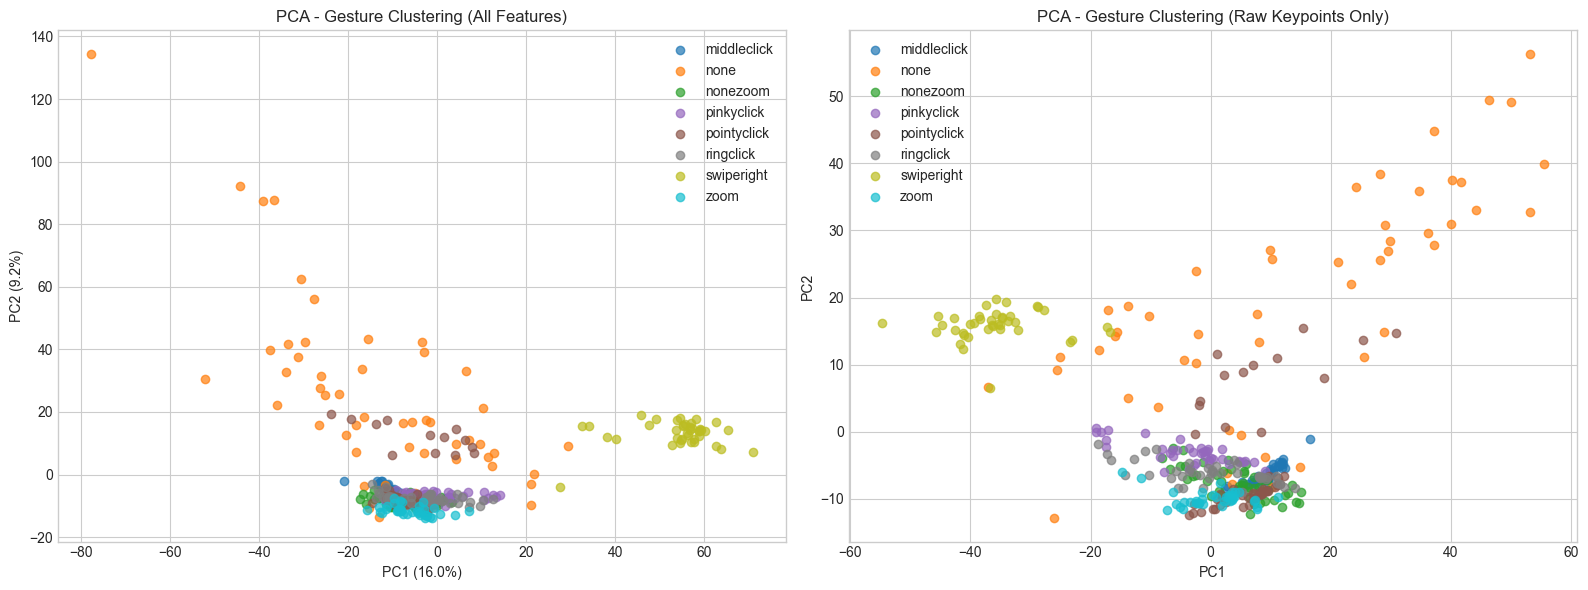

In [35]:
# Visualize PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA scatter
unique_labels = np.unique(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = labels == label
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], c=[color], label=label, alpha=0.7)

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('PCA - Gesture Clustering (All Features)')
axes[0].legend()

# Compare with raw features only
X_raw = sequences.reshape(len(sequences), -1)
X_raw_scaled = StandardScaler().fit_transform(X_raw)
X_raw_pca = PCA(n_components=2).fit_transform(X_raw_scaled)

for label, color in zip(unique_labels, colors):
    mask = labels == label
    axes[1].scatter(X_raw_pca[mask, 0], X_raw_pca[mask, 1], c=[color], label=label, alpha=0.7)

axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('PCA - Gesture Clustering (Raw Keypoints Only)')
axes[1].legend()

plt.tight_layout()
plt.savefig('../docs/pca_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary & Recommendations

In [ ]:
print("="*60)
print("📋 FEATURE ENGINEERING SUMMARY")
print("="*60)
print()
print("📊 FEATURE DIMENSIONS:")
print(f"   Base keypoints: 84 (21 landmarks × 4)")
print(f"   With all features: {engineer.get_output_dim()}")
print()
print("🔍 FEATURE IMPACT:")
print("   • Velocity: Critical for swipe detection")
print("   • Acceleration: Helps with motion dynamics")
print("   • Finger angles: Distinguishes click types")
print("   • Bbox size: Distance/zoom awareness")
print()
print("💡 RECOMMENDATIONS:")
print("   1. Enable all features initially")
print("   2. Model will learn which are important")
print("   3. Can prune later if needed for speed")
print("   4. Consider feature selection if overfitting")
print("="*60)

## Next Steps

Continue to:
- **04_model_exploration.ipynb** - Train and compare different model architectures